Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


**Завдання 1.** Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [5]:
passengers = df['Passengers'].values.astype(np.float32)
passengers[:5]

array([112., 118., 132., 129., 121.], dtype=float32)

Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

**Завдання 2**. Розбийте дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [9]:
train_size = int(len(passengers) * 0.67)
test_size = len(passengers) - train_size

train, test = passengers[:train_size], passengers[train_size:]

print("Розмір тренувальної вибірки:", len(train))
print("Розмір валідаційної вибірки:", len(test))

Розмір тренувальної вибірки: 96
Розмір валідаційної вибірки: 48


**Завдання 3**.

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхіднизх даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [12]:
import torch

def create_dataset(dataset, lookback=1):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        seq = dataset[i:(i + lookback)]
        target = dataset[i + lookback]
        X.append(seq)
        y.append(target)
     
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    
    X_tensor = torch.from_numpy(X).unsqueeze(-1)
    y_tensor = torch.from_numpy(y).unsqueeze(-1)
    
    return X_tensor, y_tensor


In [14]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1, 1]) torch.Size([95, 1])
torch.Size([47, 1, 1]) torch.Size([47, 1])


Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

При 2D виникала помилка що LSTM потребує на вхід 3D.

**Завдання 4**.

Зверніть увагу на розмірності в попередньому завданні. Ми
З допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [32]:
import torch.nn as nn
#import torch.nn.functional as F

class AirModel(nn.Module):
    def __init__(self, hidden_size, num_layers=1):
        super(AirModel, self).__init__()

        self.lstm = nn.LSTM(input_size = 1, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
      
    def forward(self, input):
        lstm_out, _ = self.lstm(input)
        output = self.linear(lstm_out[:, -1, :])
        
        return output


hidden_size=50 
num_layers=1
model = AirModel(hidden_size, num_layers)

**Завдання 5**.

Створіть об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`. Ваш DataLoader повинен виконувати наступні вимоги:

1. Використовувати клас `TensorDataset`, щоб об'єднати тензори ознак `X_train` і цільових значень `y_train`.
2. Дані повинні завантажуватися невеликими батчами розміром 8 за допомогою параметра `batch_size`.
3. Використовувати параметр `shuffle=True`, щоб дані перемішувалися перед кожною епохою тренування.


In [36]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)

batch_size = 8
train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
next(iter(train_dl))

[tensor([[[293.]],
 
         [[237.]],
 
         [[199.]],
 
         [[267.]],
 
         [[193.]],
 
         [[313.]],
 
         [[364.]],
 
         [[277.]]]),
 tensor([[259.],
         [278.],
         [184.],
         [269.],
         [181.],
         [318.],
         [347.],
         [317.]])]

**Завдання 6**.

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [39]:
import torch.nn.functional as F

loss_fn = F.mse_loss
opt = torch.optim.Adam(model.parameters(), lr=0.01)

In [41]:
def fit_return_loss(num_epochs, model, loss_fn, opt, train_dl):
    losses = []
    for epoch in range(num_epochs):
        # Ініціалізуємо акумулятор для втрат
        total_loss = 0

        for xb, yb in train_dl:
            # Генеруємо передбачення
            pred = model(xb)

            # Обчислюємо втрати
            loss = loss_fn(pred, yb)

            # Виконуємо градієнтний спуск
            loss.backward()
            opt.step()
            opt.zero_grad()

            # Накопичуємо втрати
            total_loss += loss.item()

        # Обчислюємо середні втрати для епохи
        avg_loss = total_loss / len(train_dl)
        losses.append(avg_loss)

        # Валідація раз на 100 епох
        if epoch % 100 == 0:
            model.eval()
            with torch.no_grad():
                train_rmse = torch.sqrt(loss_fn(model(X_train), y_train)).item()
                test_rmse = torch.sqrt(loss_fn(model(X_test), y_test)).item()
            model.train()
            print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

    return losses   

In [43]:
losses = fit_return_loss(2000, model, loss_fn, opt, train_dl)

Epoch 0: train RMSE 224.1543, test RMSE 420.5206
Epoch 100: train RMSE 75.4276, test RMSE 238.6510
Epoch 200: train RMSE 72.1431, test RMSE 226.2865
Epoch 300: train RMSE 71.1491, test RMSE 215.1797
Epoch 400: train RMSE 71.1494, test RMSE 214.9112
Epoch 500: train RMSE 71.1491, test RMSE 215.1855
Epoch 600: train RMSE 71.1491, test RMSE 215.0894
Epoch 700: train RMSE 71.1492, test RMSE 215.1921
Epoch 800: train RMSE 71.1491, test RMSE 215.1695
Epoch 900: train RMSE 71.1491, test RMSE 215.1746
Epoch 1000: train RMSE 71.1493, test RMSE 215.2473
Epoch 1100: train RMSE 71.1493, test RMSE 214.9402
Epoch 1200: train RMSE 71.1493, test RMSE 215.2759
Epoch 1300: train RMSE 71.1491, test RMSE 215.1243
Epoch 1400: train RMSE 71.1491, test RMSE 215.1388
Epoch 1500: train RMSE 71.1491, test RMSE 215.0181
Epoch 1600: train RMSE 71.1494, test RMSE 215.3108
Epoch 1700: train RMSE 71.1503, test RMSE 214.7199
Epoch 1800: train RMSE 71.1510, test RMSE 214.6220
Epoch 1900: train RMSE 71.1502, test RMSE 

**Завдання 7.** Побудуйте графік лосів. Зробіть висновок з графіку, чи навчилась модель?

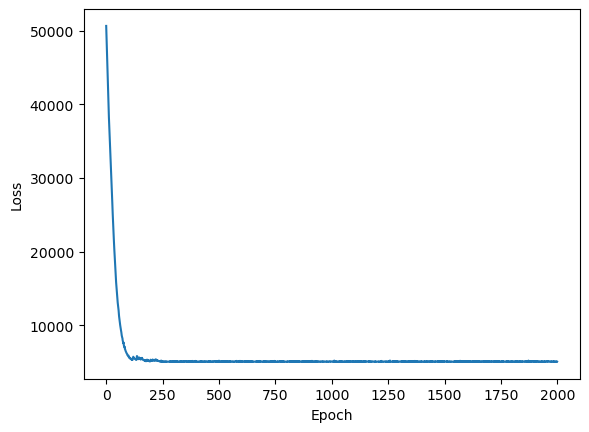

In [45]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Модель навчилась, але не факт, що точно)

Доволі неочікувано, що середньоквадратичне відхилення тестового набору даних буде на порядок більшим за одиниці в нашому наборі даних. Середньоквадратичне відхилення 100 означає, що прогноз і фактичне значення будуть відрізнятися в середньому на 100 (тобто, 100 000 пасажирів у цьому наборі даних).



Щоб краще зрозуміти якість прогнозу, ви можете побудувати графік з кодом нижче (а ще нижче - описано, що відбувається в цьому коді, бо це теж корисно зрозуміти):

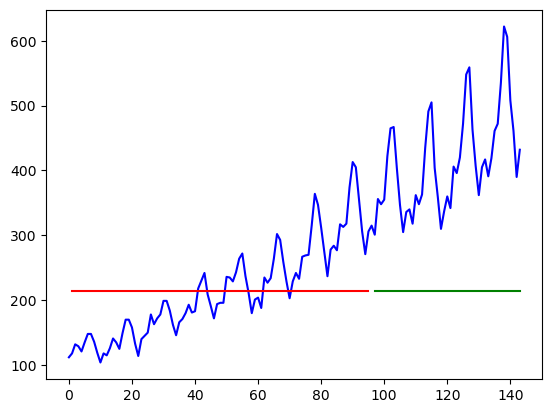

In [53]:
def plot_predicts(model):
  with torch.no_grad():
      # Зсув прогнозів для тренувальних даних
      train_plot = np.ones_like(passengers) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1]
      train_plot[lookback:train_size] = model(X_train)[:, -1]

      # Зсув прогнозів для тестових даних
      test_plot = np.ones_like(passengers) * np.nan
      test_plot[train_size+lookback:len(passengers)] = model(X_test)[:, -1]

  # Візуалізація результатів
  plt.plot(passengers, c='b')  # Реальні дані
  plt.plot(train_plot, c='r')  # Прогнози на тренувальних даних
  plt.plot(test_plot, c='g')   # Прогнози на тестових даних
  plt.show()

plot_predicts(model)

Модель навчилась лише прогнозувати середнє значенння, але не навчилась виявляти закономірності та тренд. Якість такої моделі дуже погана.

**Що відбувається в коді вище.** В цьому коді здійснюється процес прогнозування часових рядів за допомогою LSTM моделі, а також виведення графіку, який показує реальні значення, тренувальні та тестові прогнози. Ось що відбувається на кожному етапі:

1. **`torch.no_grad()`**: Цей контекстний менеджер вимикає обчислення градієнтів, що означає, що під час прогнозування не будуть зберігатися проміжні обчислення для зворотного проходу (backpropagation). Це підвищує ефективність під час прогнозування і зменшує використання пам'яті.

2. **Зсув прогнозів для тренувальних даних:**
   - Створюється масив `train_plot`, який має такий самий розмір, як і часовий ряд (`timeseries`), і заповнюється значеннями NaN (`np.nan`), щоб залишити місце для реальних значень.
   - Модель передбачає виходи для тренувальних даних `X_train`.
   - Використовується лише останнє передбачене значення для кожного входу LSTM (`y_pred[:, -1]`).
   - Прогнози зсуваються, починаючи з індексу `lookback` до кінця тренувальних даних (індекс `train_size`). Цей зсув потрібен, щоб зробити прогноз на основі попередніх даних і відобразити його на правильній частині графіку.

3. **Зсув прогнозів для тестових даних:**
   - Створюється масив `test_plot`, який також заповнюється NaN.
   - Прогнози для тестових даних додаються з індексу `train_size + lookback` до кінця реальних даних, щоб відобразити, де модель починає прогнозувати тестову вибірку.

4. **Побудова графіка:**
   - `plt.plot(timeseries, c='b')`: Виводить реальні значення часового ряду (синя лінія).
   - `plt.plot(train_plot, c='r')`: Виводить тренувальні прогнози (червона лінія).
   - `plt.plot(test_plot, c='g')`: Виводить тестові прогнози (зелена лінія).

**Чому це робиться:**
- Зсув прогнозів для тренувальних і тестових даних дозволяє візуально зрівняти, наскільки добре модель прогнозує як на тренувальній, так і на тестовій вибірках. Зазвичай, червона лінія (тренувальні прогнози) повинна точно відповідати синій лінії (реальні дані), а зелена лінія (тестові прогнози) дає змогу побачити, наскільки модель добре працює на нових даних, яких вона раніше не бачила.

**Завдання 8**. Навчіть модель з hidden_size=100 та порівняйте результати прогнозів з попередніми.

In [55]:
model_100 = AirModel(100, 1)
opt = torch.optim.Adam(model_100.parameters(), lr=0.01)

In [57]:
losses_100 = fit_return_loss(2000, model_100, loss_fn, opt, train_dl)

Epoch 0: train RMSE 221.1313, test RMSE 417.4856
Epoch 100: train RMSE 71.6576, test RMSE 223.1015
Epoch 200: train RMSE 71.6956, test RMSE 223.3752
Epoch 300: train RMSE 71.1509, test RMSE 215.5753
Epoch 400: train RMSE 71.1492, test RMSE 215.0000
Epoch 500: train RMSE 71.1492, test RMSE 214.9809
Epoch 600: train RMSE 71.1497, test RMSE 215.3828
Epoch 700: train RMSE 71.1574, test RMSE 216.1176
Epoch 800: train RMSE 71.1494, test RMSE 215.2967
Epoch 900: train RMSE 71.1511, test RMSE 215.5977
Epoch 1000: train RMSE 71.1491, test RMSE 215.1803
Epoch 1100: train RMSE 71.1493, test RMSE 215.2567
Epoch 1200: train RMSE 71.1491, test RMSE 215.1136
Epoch 1300: train RMSE 71.1491, test RMSE 215.1606
Epoch 1400: train RMSE 71.1492, test RMSE 214.9874
Epoch 1500: train RMSE 71.1491, test RMSE 215.0398
Epoch 1600: train RMSE 71.1491, test RMSE 215.1638
Epoch 1700: train RMSE 71.1491, test RMSE 215.0889
Epoch 1800: train RMSE 71.1496, test RMSE 215.3525
Epoch 1900: train RMSE 71.1491, test RMSE 

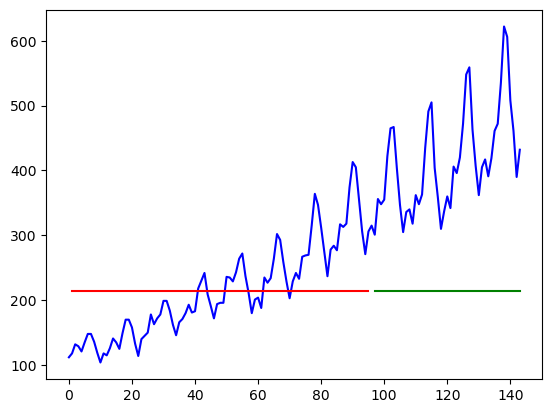

In [59]:
plot_predicts(model_100)